In [1]:
import logging
reload(logging)
logging.basicConfig(
    format='%(asctime)-9s %(levelname)-8s: %(message)s',
    datefmt='%I:%M:%S')

# Enable logging at INFO level
logging.getLogger().setLevel(logging.INFO)
# Comment the follwing line to disable devlib debugging statements
# logging.getLogger('ssh').setLevel(logging.DEBUG)

In [2]:
# Generate plots inline
%pylab inline

import json
import os

Populating the interactive namespace from numpy and matplotlib


# Test environment setup

In [3]:
# Setup a target configuration
my_target_conf = {
    
    "platform"    : 'android',
    "board"       : "hikey960",
    "device" : "0123456789ABCDEF",
    
    "ANDROID_HOME" : "/home/lisa/android-sdk",
    "rtapp-calib" : {"0": 302, "1": 302, "2": 304, "3": 304, "4": 136, "5": 137, "6": 136, "7": 136},

     "emeter" : {
        "instrument" : "acme",
        "conf" : {
            # Absolute path to the iio-capture binary on the host
            'iio-capture' : '/usr/bin/iio-capture',
            # Default host name of the BeagleBone Black
            'ip_address'     : '10.169.36.36',
        },
        "channel_map" : {
            "Device0" : 0, # iio:device0
            "Device1" : 1, # iio:device0
        }
    },

    # Binary tools required to run this experiment
    # These tools must be present in the tools/ folder for the architecture
    "tools"   : ['rt-app', 'taskset', 'trace-cmd'],

            
    # List of additional devlib modules to install 
    "modules" : ['cgroups', 'bl', 'cpufreq'],

    # Define devlib module to load
    #"modules"     : [
    #    'bl',           # enable big.LITTLE support
    #    'cpufreq'       # enable CPUFreq support
    #],

    # Account to access the remote target
    "host"        : '10.169.36.55',
    "username"    : 'root',
    "password"    : '',



}

# Setup the required Test Environment supports
my_tests_conf = {
    
    # Binary tools required to run this experiment
    # These tools must be present in the tools/ folder for the architecture
    #"tools"   : ['rt-app', 'taskset', 'trace-cmd'],
    
    # FTrace events end buffer configuration
    "ftrace"  : {
         "events" : [
             "sched_load_avg_cpu",
             "sched_load_avg_task",
             "sched_switch",
             "cpu_frequency"
             
         ],
         "buffsize" : 10240
    },

    "results_dir" : "simple_rtapp",
}

In [4]:
# Support to access the remote target
import devlib
from env import TestEnv

# Initialize a test environment using:
# the provided target configuration (my_target_conf)
# the provided test configuration   (my_test_conf)
te = TestEnv(target_conf=my_target_conf, test_conf=my_tests_conf)
target = te.target

09:07:02  INFO    : Using base path: /home/lisa/lisa-github
09:07:02  INFO    : Loading custom (inline) target configuration
09:07:02  INFO    : Loading custom (inline) test configuration
09:07:02  WARNING : Wipe previous contents of the results folder:
09:07:02  WARNING :    /home/lisa/lisa-github/results/simple_rtapp
09:07:02  INFO    : External tools using:
09:07:02  INFO    :    ANDROID_HOME: /home/lisa/android-sdk
09:07:02  INFO    :    CATAPULT_HOME: /home/lisa/lisa-github/tools/catapult
09:07:02  INFO    : Devlib modules to load: ['bl', 'cpuidle', 'cpufreq', 'cgroups']
09:07:02  INFO    : Connecting Android target [0123456789ABCDEF]
09:07:02  INFO    : Connection settings:
09:07:02  INFO    :    {'device': '0123456789ABCDEF'}
09:07:02  INFO    : Initializing target workdir:
09:07:02  INFO    :    /data/local/tmp/devlib-target
09:07:03  INFO    : Available controllers:
09:07:03  INFO    :   cpuset       : /data/local/tmp/devlib-target/cgroups/devlib_cgh5
09:07:04  INFO    :   cpu

# Workload configuration

In [5]:
# Support to configure and run RTApp based workloads
from wlgen import RTA, Periodic, Ramp

# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'simple', calibration=te.calibration())

# Configure this RTApp instance to:
rtapp.conf(
    # 1. generate a "profile based" set of tasks
    kind='profile',
    
    # 2. define the "profile" of each task
    params={
        
        # 3. PERIODIC task with
        'task_p20': Periodic(
            period_ms=100,         # period
            duty_cycle_pct=20,     # duty cycle
            duration_s=5,          # duration    
            cpus='0'               # pinned on CPU0
        ).get(),
        
        # 4. RAMP task (i.e. increasing load) with
        'task_r20_5-60': Ramp(
            start_pct=5,           # intial load
            end_pct=65,            # end load
            delta_pct=20,          # load % increase...
            time_s=1,              # ... every 1[s]
            # pinned on last CPU of the target
            cpus=str(len(target.core_names)-1)
        ).get(),
    },
    
    # 4. use this folder for task logfiles
    run_dir=target.working_directory
    
);

09:07:09  INFO    : Setup new workload simple
09:07:09  INFO    : Workload duration defined by longest task
09:07:09  INFO    : Default policy: SCHED_OTHER
09:07:09  INFO    : ------------------------
09:07:09  INFO    : task [task_p20], sched: using default policy
09:07:09  INFO    :  | loops count: 1
09:07:09  INFO    :  | CPUs affinity: 0
09:07:09  INFO    : + phase_000001: duration 5.000000 [s] (50 loops)
09:07:09  INFO    : |  period   100000 [us], duty_cycle  20 %
09:07:09  INFO    : |  run_time  20000 [us], sleep_time  80000 [us]
09:07:09  INFO    : ------------------------
09:07:09  INFO    : task [task_r20_5-60], sched: using default policy
09:07:09  INFO    :  | loops count: 1
09:07:09  INFO    :  | CPUs affinity: 7
09:07:09  INFO    : + phase_000001: duration 1.000000 [s] (10 loops)
09:07:09  INFO    : |  period   100000 [us], duty_cycle   5 %
09:07:09  INFO    : |  run_time   5000 [us], sleep_time  95000 [us]
09:07:09  INFO    : + phase_000002: duration 1.000000 [s] (10 loo

# Workload execution

In [6]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
nrg_report = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

09:07:10  INFO    : #### Setup FTrace
09:07:12  INFO    : #### Start energy sampling


09:07:13  INFO    : #### Start RTApp execution
09:07:13  INFO    : Workload execution START:
09:07:13  INFO    :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/simple_00.json 2>&1
09:07:18  INFO    : #### Read energy consumption: /home/lisa/lisa-github/results/simple_rtapp/energy.json
09:07:22  INFO    : #### Stop FTrace
09:07:22  INFO    : #### Save FTrace: /home/lisa/lisa-github/results/simple_rtapp/trace.dat
09:07:24  INFO    : #### Save platform description: /home/lisa/lisa-github/results/simple_rtapp/platform.json


# Collected results

In [7]:
# All data are produced in the output folder defined by the TestEnv module
logging.info('Content of the output folder %s', te.res_dir)
!ls -la {te.res_dir}

09:07:31  INFO    : Content of the output folder /home/lisa/lisa-github/results/simple_rtapp


total 5412
drwxrwxr-x 1 lisa lisa     318 Aug 25 09:07 .
drwxrwxr-x 1 lisa lisa    1522 Aug 25 09:07 ..
-rw-rw-r-- 1 lisa lisa      47 Aug 25 09:07 energy.json
-rw-rw-r-- 1 lisa lisa     382 Aug 25 09:07 energy_stats.json
-rw-rw-r-- 1 lisa lisa     307 Aug 25 09:07 output.log
-rw-rw-r-- 1 lisa lisa    1519 Aug 25 09:07 platform.json
-rw-r--r-- 1 lisa lisa    6360 Aug 25 09:07 rt-app-task_p20-0.log
-rw-r--r-- 1 lisa lisa    5120 Aug 25 09:07 rt-app-task_r20_5-60-1.log
-rw-rw-r-- 1 lisa lisa   27769 Aug 25 09:07 samples_Device0.csv
-rw-rw-r-- 1 lisa lisa   28339 Aug 25 09:07 samples_Device1.csv
-rw-r--r-- 1 lisa lisa    1838 Aug 25 09:07 simple_00.json
-rw-r--r-- 1 lisa lisa 5447680 Aug 25 09:07 trace.dat


In [8]:
!cat {te.res_dir}/rt-app-task_p20-0.log

# Policy : SCHED_OTHER priority : 0
#idx     perf      run   period           start             end          rel_st      slack c_duration   c_period     wu_lat
   0   147058    59551   100653       450543216       450643868            4255      38872      20000     100000       2217
   0   147058    59529    99992       450643882       450743874          104921      38236      20000     100000       2223
   0   147058    59842    99972       450743882       450843854          204921      37923      20000     100000       2204
   0   147058    78116    97997       450843863       450941860          304902      19670      20000     100000        209
   0   147058    45769   100099       450941869       451041968          402908      54010      20000     100000        317
   0   147058    45369   101795       451041974       451143770          503014      54305      20000     100000       2119
   0   147058    45423   100010       451143776       451243786          604815      52449      

In [9]:
# Inspect the JSON file used to run the application
with open('{}/simple_00.json'.format(te.res_dir), 'r') as fh:
    rtapp_json = json.load(fh, )
logging.info('Generated RTApp JSON file:')
print json.dumps(rtapp_json, indent=4, sort_keys=True)

09:07:33  INFO    : Generated RTApp JSON file:


{
    "global": {
        "calibration": 136, 
        "default_policy": "SCHED_OTHER", 
        "duration": -1, 
        "logdir": "/data/local/tmp/devlib-target"
    }, 
    "tasks": {
        "task_p20": {
            "cpus": [
                0
            ], 
            "loop": 1, 
            "phases": {
                "p000001": {
                    "loop": 50, 
                    "run": 20000, 
                    "timer": {
                        "period": 100000, 
                        "ref": "task_p20"
                    }
                }
            }, 
            "policy": "SCHED_OTHER"
        }, 
        "task_r20_5-60": {
            "cpus": [
                7
            ], 
            "loop": 1, 
            "phases": {
                "p000001": {
                    "loop": 10, 
                    "run": 5000, 
                    "timer": {
                        "period": 100000, 
                        "ref": "task_r20_5-60"
                    }


In [10]:
# Dump the energy measured for the LITTLE and big clusters
logging.info('Energy: %s', nrg_report.report_file)
print json.dumps(nrg_report.channels, indent=4, sort_keys=True)

09:07:35  INFO    : Energy: /home/lisa/lisa-github/results/simple_rtapp/energy.json


{
    "Device0": 0.0, 
    "Device1": 12226.1
}


In [11]:
# Dump the platform descriptor, which could be useful for further analysis
# of the generated results
logging.info('Platform description: %s', plt_file)
print json.dumps(plt, indent=4, sort_keys=True)

09:07:35  INFO    : Platform description: /home/lisa/lisa-github/results/simple_rtapp/platform.json


{
    "abi": "arm64", 
    "clusters": {
        "big": [
            4, 
            5, 
            6, 
            7
        ], 
        "little": [
            0, 
            1, 
            2, 
            3
        ]
    }, 
    "cpus_count": 8, 
    "freqs": {
        "big": [
            903000, 
            1421000, 
            1805000, 
            2112000, 
            2362000
        ], 
        "little": [
            533000, 
            999000, 
            1402000, 
            1709000, 
            1844000
        ]
    }, 
    "kernel": {
        "major": 4, 
        "minor": 79, 
        "parts": [
            4, 
            4, 
            79
        ], 
        "rc": null, 
        "release": "4.4.79-g4a80fc6", 
        "sha1": "4a80fc6", 
        "version": "13 SMP PREEMPT Thu Aug 17 15:40:29 CST 2017", 
        "version_number": 4
    }, 
    "nrg_model": {
        "big": {
            "cluster": {
                "nrg_max": 413
            }, 
            "cp

# Trace inspection

In [12]:
# Suport for FTrace events parsing and visualization
import trappy

# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(te.res_dir)

In [13]:
my_events = [
    "sched_load_avg_cpu",
    "sched_load_avg_task",
    "cpu_frequency",
    "cpu_capacity"
]

ftrace = trappy.FTrace(
    name="PandasExamples",
    path=trace_file,
    scope='custom',
    events=my_events,
    window=(0,None))


my_signals = [
    'sched_load_avg_task:util_avg',
#     'sched_load_avg_cpu:util_cpu'
]

# These two paramatere are passed to the LinePlot call as long with the
# TRAPpy FTrace object
trappy.ILinePlot(
    
    # FTrace object
    ftrace,
    
    # Signals to be plotted
    signals=my_signals,
    
    # Generate one plot for each value of the specified column
    pivot='pid',
    
    # Generate only plots which satisfy these filters
    filters = {
       'comm' : 'task_r20_5-60'
    
    },
    
    # Formatting style
    drawstyle='steps-post',
    marker = '+'

).view()

""
""


# RTApp task performance plots

09:07:42  INFO    : PerfIndex, Task [task_p20] avg: 0.53, std: 0.15
09:07:44  INFO    : PerfIndex, Task [task_r20_5-60] avg: 0.84, std: 0.18


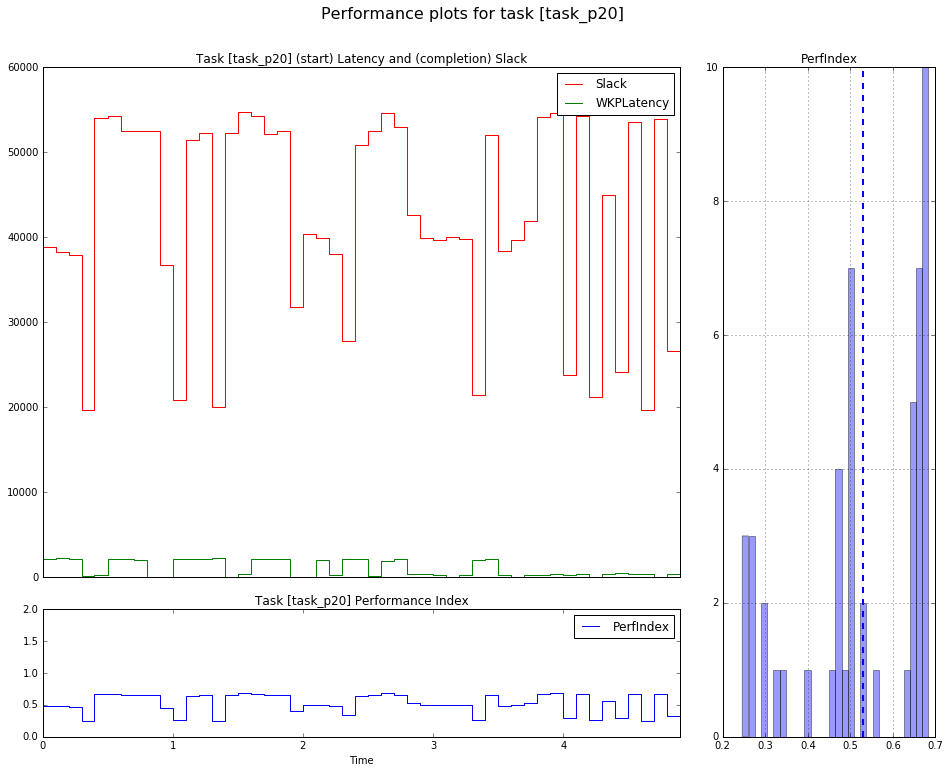

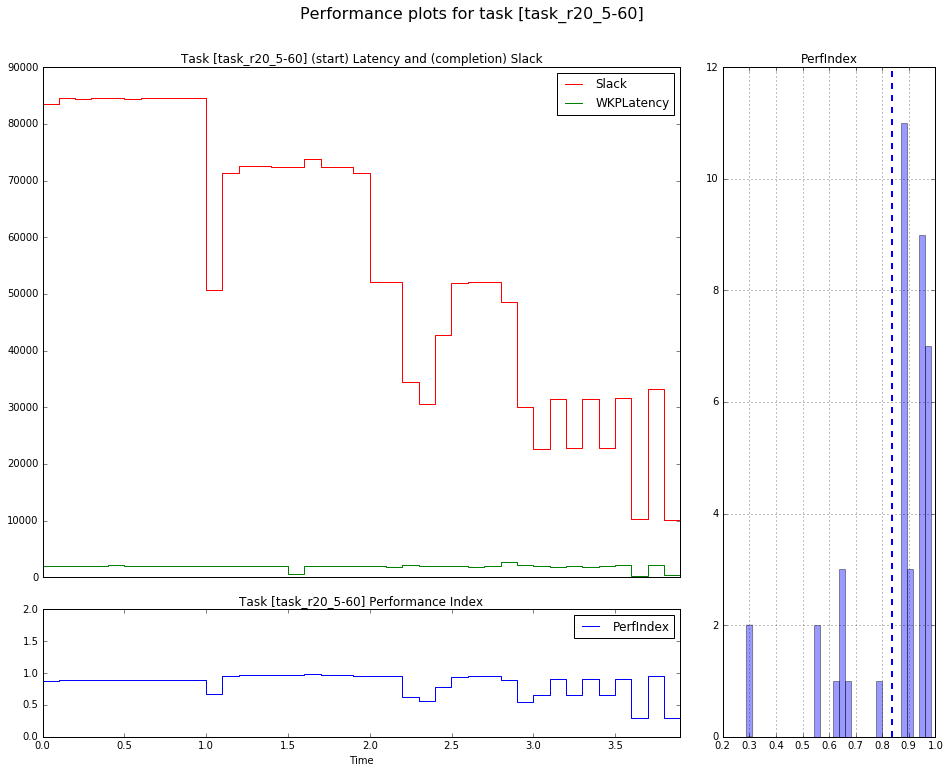

In [14]:
# Support for performance analysis of RTApp workloads
from perf_analysis import PerfAnalysis

# Parse the RT-App generate log files to compute performance metrics
pa = PerfAnalysis(te.res_dir)

# For each task which has generated a logfile, plot  its performance metrics
for task in pa.tasks():
    pa.plotPerf(task, "Performance plots for task [{}] ".format(task))